In [1]:
Reset_initial = True

if Reset_initial:
    %run -i 'initial.py'

-471.0568564937796
2020-05-31 04:48:48,627 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+01/s
2020-05-31 04:48:48,639 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+02/s
2020-05-31 04:48:48,642 __main__ 0/1 INFO :: Perturbation norm: 17.365219865144315
2020-05-31 04:48:48,642 __main__ 0/1 INFO :: T iterate: 2.268591126035416
2020-05-31 04:48:48,643 __main__ 0/1 INFO :: P iterate: 11.937870498209637
2020-05-31 04:48:48,673 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2020-05-31 04:48:48,678 __main__ 0/1 INFO :: Perturbation norm: 4.548874464065178
2020-05-31 04:48:48,678 __main__ 0/1 INFO :: T iterate: 2.4780799537499414
2020-05-31 04:48:48,678 __main__ 0/1 INFO :: P iterate: 12.686044882904369
2020-05-31 04:48:48,692 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2020-05-31 04:48:48,696 __mai

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py


from dedalus import public as de
from dedalus.extras.plot_tools import quad_mesh, pad_limits

import logging
logger = logging.getLogger(__name__)

%matplotlib inline

import time

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

from dedalus.extras import plot_tools

In [3]:
a_1 = 1 # Location of disk 
AU = 1.496e13
Mp = 0.2 # Earth masses
T_disk = 300 *a_1**(-1/2)

rho_disk = 2.4e-9*a_1**(-11/4)
r_Hill = 2e11*a_1*(Mp)**(1/3)
r_Bondi = 4e10*a_1**(1/2)*Mp

print('disk temperature: ' + str(T_disk))
print('disk density: ' + str(rho_disk))
print('hill radius: {:.4e}'.format(r_Hill))
print('bondi radius: {:.4e}'.format(r_Bondi))

disk temperature: 300.0
disk density: 2.4e-09
hill radius: 1.1696e+11
bondi radius: 8.0000e+09


In [4]:
# Basis and domain

resolution = 256 #500
# normalization factors
r_0 = 1.2e8
T_0 = 1000
P_0 = 1 #1e5 #1
M_0 = 1e-12
# r_outer = 1.496e13/r_0
r_outer = 1.2e12/r_0
r_outer = r_Hill / r_0 #3.4199512e11/r_0
r_inner = 1.2e9/r_0

log_inner = np.log(r_inner) 
log_outer = np.log(r_outer)

log_basis = de.Chebyshev('r', resolution, interval=(log_inner,log_outer))  
domain = de.Domain([log_basis], np.float64)

In [5]:
# Problem

ncc_cutoff = 1e-10 #1e-2
tolerance = 1e-10 #1e-2
# P and T are actually log(P) and log(T)
problem = de.NLBVP(domain,variables = ['lgP', 'lgT', 'lgM', 'lgZgr'], ncc_cutoff = ncc_cutoff)


In [6]:
# Parameters

problem.parameters['T_0'] = T_0 
problem.parameters['r_0'] = r_0
problem.parameters['P_0'] = P_0 
problem.parameters['M_0'] = M_0

lgP = domain.new_field(name='lgP')
lgT = domain.new_field(name='lgT')
lgZgr = domain.new_field(name='lgZgr')
lgM = domain.new_field(name='lgM')

r = domain.new_field(name='R')
r['g'] = domain.grid(0)
S = np.exp(r['g']) * r_0

pi = np.pi 
Core_mass = Mp*5.972e27
Mc = Core_mass # 5* mass of earth (in g)
mu = 2.34 * 1.6735575e-24 #mH multiplied by hydrogen atom mass 
kb = 1.38064852e-16 # g*cm**2/(K*s**2)
G = 6.67408e-8 # cm**3/(g*s**2)
dMtot = 1e-5*5.972e27/3.154e7 # 10e-5* mass of earth, g/s #3.154e7 is conversion from yr to s
sig = 5.670367e-5 # (cgs units) e-5 in g/(K^4s^3), Stefan Boltzmann Const (normally it's e-8 in [W⋅m−2⋅K−4])
s0 = 1e-4 # cm
rho_o = 3 #g cm^-3 grain internal density
sigma_b = 5.6704e-5 # erg*cm^-2*s^-1*K^-4 Stefan Boltzmann 
rcore = 1.2e9
grad_rad_cst = - 3*dMtot/(64*np.pi*rcore*sig)

rhodisk = rho_disk # 7.5e-9 #g/cm**3
Tdisk = T_disk # 370 # kelvin

Core_mass = Mp*5.972e27 # 5*5.972e27
problem.parameters['pi'] = np.pi
problem.parameters['Mc'] = Core_mass # 5* mass of earth (in g)
problem.parameters['mu'] = mu #mH multiplied by hydrogen atom mass 
problem.parameters['kb'] = kb # g*cm**2/(K*s**2)
problem.parameters['G'] = G # cm**3/(g*s**2)
problem.parameters['dMtot'] = dMtot # 10e-5* mass of earth, g/s #3.154e7 is conversion from yr to s
problem.parameters['sig'] = sig # (cgs units) e-5 in g/(K^4s^3), Stefan Boltzmann Const (normally it's e-8 in [W⋅m−2⋅K−4])
problem.parameters['s0'] = s0 # cm
problem.parameters['rho_o'] = rho_o #g cm^-3 grain internal density
problem.parameters['sigma_b'] = sigma_b # erg*cm^-2*s^-1*K^-4 Stefan Boltzmann 
problem.parameters['grad_rad_cst'] = grad_rad_cst

problem.parameters['rhodisk'] = rhodisk #g/cm**3
problem.parameters['Tdisk'] = Tdisk # kelvin

problem.substitutions['s'] = "(exp(lgM)*M_0*3/(4*pi*rho_o))**(1/3)" # radius
s = (np.exp(lgM)*M_0*3/(4*pi*rho_o))**(1/3)

In [7]:
# Opacity


problem.substitutions['x'] = '2*pi*s*0.3/0.2898'
x = 2*pi*s*0.3/0.2898
 
k0 = -10. # -30.
problem.parameters['k0'] = k0

problem.substitutions['Qe'] = "(0.5*(2**k0 + (x*exp(lgT)*T_0)**k0))**(1/k0)"
Qe = (0.5*(2**k0 + (x*np.exp(lgT)*T_0)**k0))**(1/k0)
# problem.substitutions['Qe'] = "x*exp(lgT)*T_0 + 0.5*(2 - x*exp(lgT)*T_0)*tanh((x*T_0*exp(lgT) - 2)/2*10 + 1)" 

problem.substitutions['Qk_geo'] = "Qe*3/4*exp(lgZgr)/(s*rho_o)"
Qk_geo = Qe*3/4*np.exp(lgZgr)/(s*rho_o)

k_gas_cst = 1e-8*(problem.parameters["mu"]/problem.parameters['kb'])**(2/3)
problem.parameters['k_gas_cst'] = k_gas_cst

problem.substitutions['k_gas'] = "k_gas_cst*(exp(lgT)*T_0)**(7/3)*(exp(lgP)*P_0)**(2/3)"
k_gas = k_gas_cst*(np.exp(lgT)*T_0)**(7/3)*(np.exp(lgP)*P_0)**(2/3)

problem.substitutions['kappa'] = "k_gas + Qk_geo"
kappa = k_gas + Qk_geo 

In [8]:
# Gradient  

# problem.parameters['grad_rad_cst'] = -3/64*np.pi*problem.parameters['dMtot']/(problem.parameters['sigma_b']*rcore)
problem.substitutions['grad_rad'] = "grad_rad_cst*kappa*exp(lgP)*P_0/(exp(lgT)*T_0)**4"
grad_rad = grad_rad_cst*kappa*np.exp(lgP)*P_0/(np.exp(lgT)*T_0)**4

grad_ad = 0.28
problem.parameters['grad_ad'] = grad_ad

# min
k1 = -10. # -30.
problem.parameters['k1'] = k1

grad = (0.5*(grad_rad**k1 + (grad_ad)**k1))**(1/k1)
problem.substitutions['grad'] = "(0.5*(grad_rad**k1 + (grad_ad)**k1))**(1/k1)" 


In [9]:
# Tstop: v_set = gm/r^2 * Tstop 

gm = problem.parameters['Mc']*problem.parameters['G']
problem.parameters['gm'] = gm

problem.substitutions['rho_g'] = '(exp(lgP)*P_0*mu)/(kb*exp(lgT)*T_0)'
rho_g = (np.exp(lgP)*P_0*mu)/(kb*np.exp(lgT)*T_0)

problem.substitutions['cg'] = 'sqrt(kb*exp(lgT)*T_0/mu)'
cg = np.sqrt(kb*np.exp(lgT)*T_0/mu)

# problem.substitutions['Lg'] = '1.30537485e-9/rho_g'
problem.substitutions['Lg'] = '1e-9/rho_g'
Lg = 1e-9/rho_g

l = 10 #1 #15
problem.parameters['l'] = l
problem.substitutions['max'] = "(0.5*(1 + (s/Lg)**l))**(1/l)"
Max = (0.5*(1 + (s/Lg)**l))**(1/l)

problem.substitutions['Tstop'] = '(max*4*rho_o*s)/(9*cg*rho_g)'
Tstop = (Max*4*rho_o*s)/(9*cg*rho_g)

problem.substitutions['v_set'] = 'gm*Tstop/(exp(r)*r_0)**2'
v_set = gm*Tstop/(np.exp(r)*r_0)**2

In [10]:
# Tgrow 

problem.substitutions['v_bm'] = 'sqrt(16*kb*exp(lgT)*T_0/(pi*exp(lgM)*M_0))'
v_bm = np.sqrt(16*kb*np.exp(lgT)*T_0/(np.pi*np.exp(lgM)*M_0))

problem.substitutions['v_dd'] = '0.1*v_set'
v_dd = 0.1*v_set

problem.substitutions['Tgrow_inv'] = '3*exp(lgZgr)*rho_g*(v_bm+v_dd)/(rho_o*s)'
Tgrow_inv = 3*np.exp(lgZgr)*rho_g*(v_bm+v_dd)/(rho_o*s)

In [11]:
# New equations

dMdep = 5e-9*5.972e27/3.154e7 
problem.parameters['dMdep'] = dMdep

problem.add_equation('lgZgr = log(dMdep/(4*pi*gm*Tstop*rho_g))')
problem.add_equation('dr(lgM) = -Tgrow_inv*(exp(r)*r_0)**3/(gm*Tstop)')

In [12]:
# Normalized equations

# problem.parameters['eq1cst'] = -1*problem.parameters['G']*problem.parameters['Mc']*problem.parameters['mu']/(T_0*r_0*problem.parameters['kb'])
problem.add_equation('exp(r) * dr(lgP) = -gm*mu/(T_0*r_0*kb*exp(lgT))')
problem.add_equation('dr(lgT) = dr(lgP)*grad')

In [13]:
# Boundary Equations


problem.add_bc("right(lgT) = log(Tdisk/T_0)") # disk temp in kelvins
problem.add_bc("right(lgP) = log(rhodisk*kb*Tdisk/mu/P_0)") # gas law
problem.add_bc("right(lgZgr) = log(1e-3)") 

In [14]:
# solver = problem.build_solver(de.timesteppers.RK443)
solver = problem.build_solver()

2020-05-31 04:48:49,821 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.7e+01/s


Text(0.5, 1.0, 'lgM')

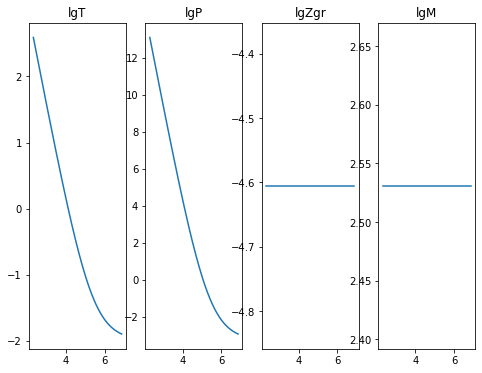

In [15]:
# initial conditions and referencing local grid state fields

lgr = domain.grid(0)
R = np.exp(lgr)*r_0
lgT1 = solver.state['lgT']
lgP1 = solver.state['lgP']
lgZgr1 = solver.state['lgZgr']
lgM1 = solver.state['lgM']

# Load from constant version
lgP_initial = np.loadtxt("Pressure.txt")
lgT_initial = np.loadtxt("Temperature.txt")
lgP1['g'] = lgP_initial
lgT1['g'] = lgT_initial
ones = lgT1['g']/lgT1['g']


if not Reset_initial:
    lgM1['g'] = np.loadtxt('M.txt')
    lgZgr1['g'] = np.loadtxt('Zgr.txt')

else:
    lgZgr1['g'] = np.log(ones * 1e-2)
    #previously s was 1e-4
    lgM1['g'] = np.log(ones * 4/3*np.pi*problem.parameters['rho_o']*(1e-4)**3/ M_0) 


plt.figure(figsize=(8,6))
plt.subplot(1,4,1)
plt.plot(domain.grid(0),lgT1['g'])
plt.title("lgT")
plt.subplot(1,4,2)
plt.plot(domain.grid(0), lgP1['g'])
plt.title("lgP")
plt.subplot(1,4,3)
plt.plot(domain.grid(0),lgZgr1['g'])
plt.title("lgZgr")
plt.subplot(1,4,4)
plt.plot(domain.grid(0), lgM1['g'])
plt.title("lgM")

In [16]:
# Analysis 

# output = solver.evaluator.add_file_handler('output', iter =1 , max_writes = 100, mode='overwrite')
# output.add_task("exp(r)*r_0/v_set", layout ='g', name ='T_set')

# analysis = solver.evaluator.add_file_handler('analysis', wall_dt = 30)
# analysis.add_task("exp(r)*r_0/v_set", layout ='g', name ='T_set')

In [17]:
lgT_list = [np.copy(lgT['g'])]
lgP_list = [np.copy(lgP['g'])]
lgZgr_list = [np.copy(lgZgr['g'])]
lgM_list = [np.copy(lgM['g'])]

2020-05-31 04:48:51,887 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.6e+00/s
2020-05-31 04:48:51,983 __main__ 0/1 INFO :: Perturbation norm: 45.74755547628304
2020-05-31 04:48:51,984 __main__ 0/1 INFO :: lgT iterate: 1.1419209903337917
2020-05-31 04:48:51,985 __main__ 0/1 INFO :: lgP iterate: 3.7684204339111798
2020-05-31 04:48:51,985 __main__ 0/1 INFO :: lgM iterate: -4.568628922441032
2020-05-31 04:48:51,986 __main__ 0/1 INFO :: lgZgr iterate: 3.292695959622608


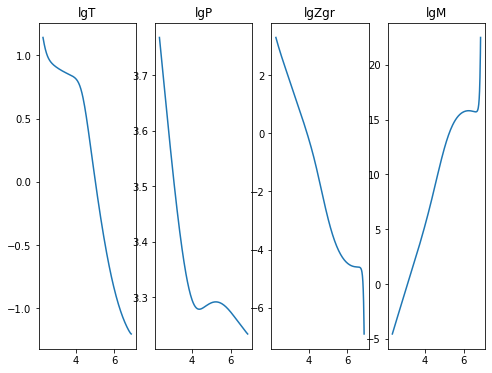

2020-05-31 04:48:53,948 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+00/s
2020-05-31 04:48:54,102 __main__ 0/1 INFO :: Perturbation norm: 15.665365146856589
2020-05-31 04:48:54,103 __main__ 0/1 INFO :: lgT iterate: -0.5825024594402715
2020-05-31 04:48:54,103 __main__ 0/1 INFO :: lgP iterate: 5.523831434203429
2020-05-31 04:48:54,104 __main__ 0/1 INFO :: lgM iterate: -0.959141100438405
2020-05-31 04:48:54,105 __main__ 0/1 INFO :: lgZgr iterate: 1.22732162739793


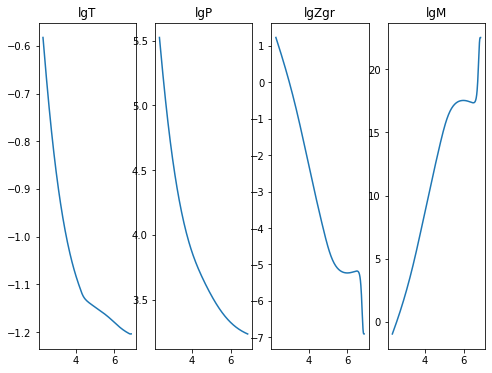

2020-05-31 04:48:56,327 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s
2020-05-31 04:48:56,532 __main__ 0/1 INFO :: Perturbation norm: 9.447479865936904
2020-05-31 04:48:56,533 __main__ 0/1 INFO :: lgT iterate: -0.19844705227714365
2020-05-31 04:48:56,534 __main__ 0/1 INFO :: lgP iterate: 6.731425438540429
2020-05-31 04:48:56,535 __main__ 0/1 INFO :: lgM iterate: 1.2335678277571844
2020-05-31 04:48:56,535 __main__ 0/1 INFO :: lgZgr iterate: 0.6884463544864485


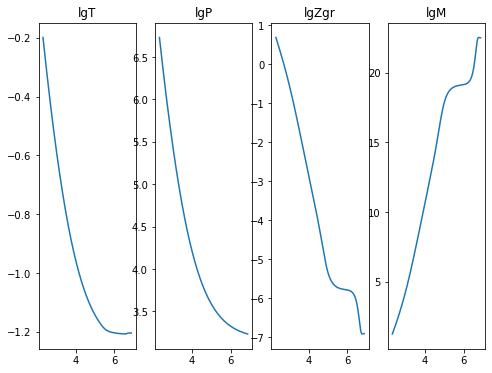

2020-05-31 04:48:58,659 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+00/s
2020-05-31 04:48:58,808 __main__ 0/1 INFO :: Perturbation norm: 8.042534984032097
2020-05-31 04:48:58,809 __main__ 0/1 INFO :: lgT iterate: -0.20380521694548304
2020-05-31 04:48:58,810 __main__ 0/1 INFO :: lgP iterate: 7.053302421526697
2020-05-31 04:48:58,810 __main__ 0/1 INFO :: lgM iterate: 2.4107718389761352
2020-05-31 04:48:58,811 __main__ 0/1 INFO :: lgZgr iterate: 0.2933659357929219


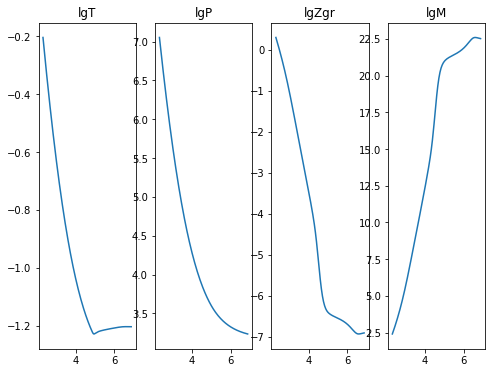

2020-05-31 04:49:01,111 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s
2020-05-31 04:49:01,257 __main__ 0/1 INFO :: Perturbation norm: 9.829857533546626
2020-05-31 04:49:01,258 __main__ 0/1 INFO :: lgT iterate: -0.22522255497648913
2020-05-31 04:49:01,261 __main__ 0/1 INFO :: lgP iterate: 7.1748486274921754
2020-05-31 04:49:01,262 __main__ 0/1 INFO :: lgM iterate: 3.3843664289083044
2020-05-31 04:49:01,265 __main__ 0/1 INFO :: lgZgr iterate: -0.04187426370977798


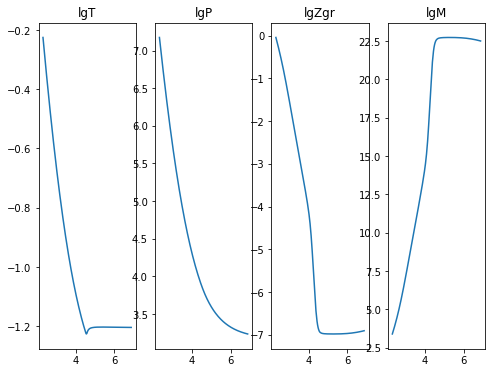

2020-05-31 04:49:03,858 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s
2020-05-31 04:49:04,068 __main__ 0/1 INFO :: Perturbation norm: 11.323846415024486
2020-05-31 04:49:04,069 __main__ 0/1 INFO :: lgT iterate: -0.24643380364267164
2020-05-31 04:49:04,073 __main__ 0/1 INFO :: lgP iterate: 7.285676304938739
2020-05-31 04:49:04,073 __main__ 0/1 INFO :: lgM iterate: 4.442333211519008
2020-05-31 04:49:04,077 __main__ 0/1 INFO :: lgZgr iterate: -0.40513548199366367


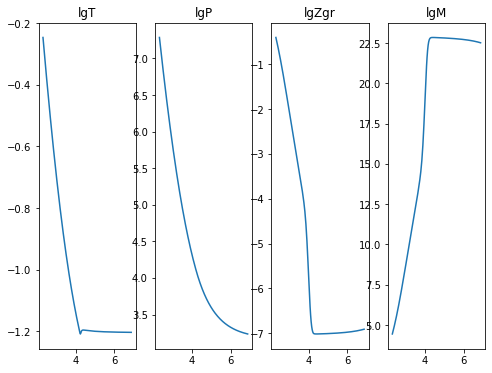

2020-05-31 04:49:06,822 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s
2020-05-31 04:49:06,994 __main__ 0/1 INFO :: Perturbation norm: 11.770509298828939
2020-05-31 04:49:06,995 __main__ 0/1 INFO :: lgT iterate: -0.27561978941711496
2020-05-31 04:49:06,999 __main__ 0/1 INFO :: lgP iterate: 7.4324132422921565
2020-05-31 04:49:06,999 __main__ 0/1 INFO :: lgM iterate: 5.706139494876238
2020-05-31 04:49:07,002 __main__ 0/1 INFO :: lgZgr iterate: -0.8409972360813085


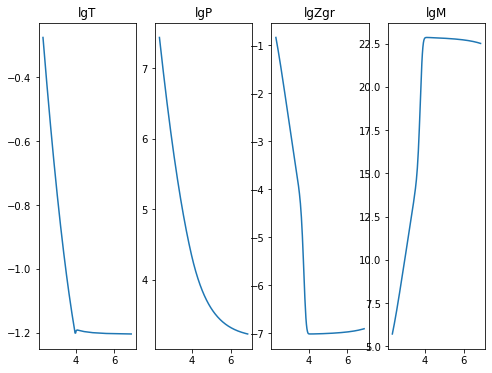

2020-05-31 04:49:09,713 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+00/s
2020-05-31 04:49:09,966 __main__ 0/1 INFO :: Perturbation norm: 11.816219799207753
2020-05-31 04:49:09,967 __main__ 0/1 INFO :: lgT iterate: -0.31003076087679
2020-05-31 04:49:09,970 __main__ 0/1 INFO :: lgP iterate: 7.595861655617409
2020-05-31 04:49:09,971 __main__ 0/1 INFO :: lgM iterate: 7.188584187169751
2020-05-31 04:49:09,974 __main__ 0/1 INFO :: lgZgr iterate: -1.3523509559613665


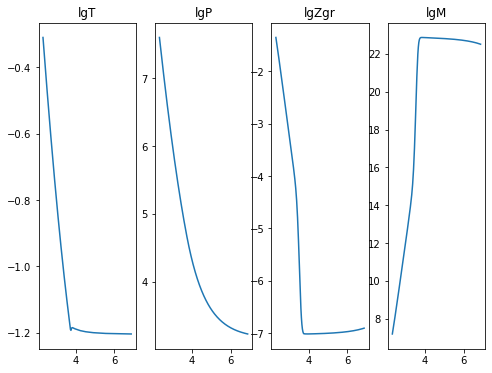

2020-05-31 04:49:12,730 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+00/s
2020-05-31 04:49:12,913 __main__ 0/1 INFO :: Perturbation norm: 11.310272645313479
2020-05-31 04:49:12,914 __main__ 0/1 INFO :: lgT iterate: -0.34907157019758484
2020-05-31 04:49:12,915 __main__ 0/1 INFO :: lgP iterate: 7.767386804717978
2020-05-31 04:49:12,916 __main__ 0/1 INFO :: lgM iterate: 8.849978325784578
2020-05-31 04:49:12,917 __main__ 0/1 INFO :: lgZgr iterate: -1.9256693437237224


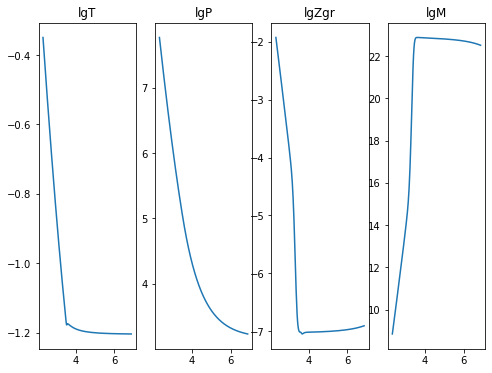

2020-05-31 04:49:15,877 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s
2020-05-31 04:49:16,065 __main__ 0/1 INFO :: Perturbation norm: 11.741075577648674
2020-05-31 04:49:16,066 __main__ 0/1 INFO :: lgT iterate: -0.3982756332490523
2020-05-31 04:49:16,070 __main__ 0/1 INFO :: lgP iterate: 7.962012365678076
2020-05-31 04:49:16,071 __main__ 0/1 INFO :: lgM iterate: 10.641359258707759
2020-05-31 04:49:16,075 __main__ 0/1 INFO :: lgZgr iterate: -2.5473984624372905


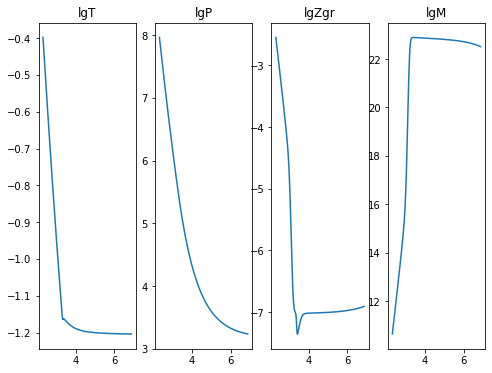

2020-05-31 04:49:18,934 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s
2020-05-31 04:49:19,149 __main__ 0/1 INFO :: Perturbation norm: 11.468806504335138
2020-05-31 04:49:19,150 __main__ 0/1 INFO :: lgT iterate: -0.46712668303655336
2020-05-31 04:49:19,154 __main__ 0/1 INFO :: lgP iterate: 8.199417412285982
2020-05-31 04:49:19,155 __main__ 0/1 INFO :: lgM iterate: 12.550242708654709
2020-05-31 04:49:19,158 __main__ 0/1 INFO :: lgZgr iterate: -3.2181209057597133


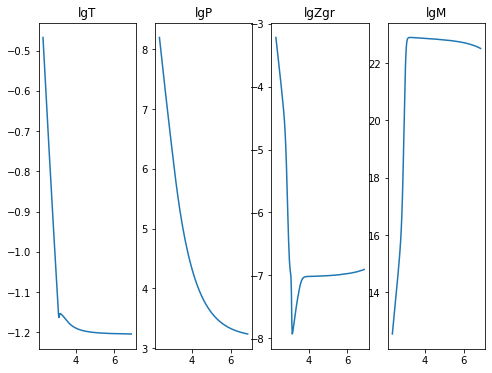

2020-05-31 04:49:22,090 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s
2020-05-31 04:49:22,309 __main__ 0/1 INFO :: Perturbation norm: 11.814975543745131
2020-05-31 04:49:22,310 __main__ 0/1 INFO :: lgT iterate: -0.5476747119249968
2020-05-31 04:49:22,311 __main__ 0/1 INFO :: lgP iterate: 8.436730976159687
2020-05-31 04:49:22,311 __main__ 0/1 INFO :: lgM iterate: 14.499017567442586
2020-05-31 04:49:22,312 __main__ 0/1 INFO :: lgZgr iterate: -3.9084834218792066


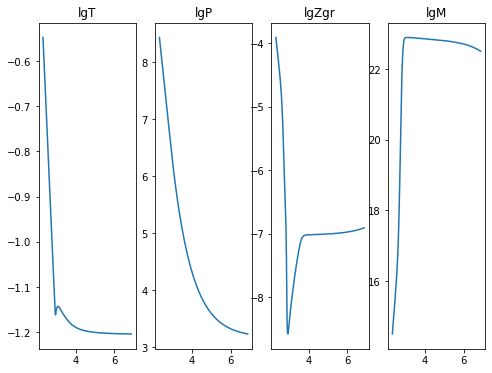

2020-05-31 04:49:25,458 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s
2020-05-31 04:49:25,795 __main__ 0/1 INFO :: Perturbation norm: 11.405637767335163
2020-05-31 04:49:25,796 __main__ 0/1 INFO :: lgT iterate: -0.6274641075780585
2020-05-31 04:49:25,823 __main__ 0/1 INFO :: lgP iterate: 8.623836456997982
2020-05-31 04:49:25,824 __main__ 0/1 INFO :: lgM iterate: 15.384605981097884
2020-05-31 04:49:25,826 __main__ 0/1 INFO :: lgZgr iterate: -4.9519954031025355


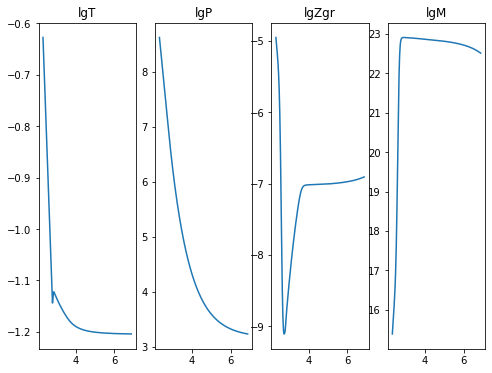

2020-05-31 04:49:28,560 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s
2020-05-31 04:49:28,737 __main__ 0/1 INFO :: Perturbation norm: 12.186294529323348
2020-05-31 04:49:28,737 __main__ 0/1 INFO :: lgT iterate: -0.7651059761863857
2020-05-31 04:49:28,741 __main__ 0/1 INFO :: lgP iterate: 8.842373384054705
2020-05-31 04:49:28,742 __main__ 0/1 INFO :: lgM iterate: 16.682362785294757
2020-05-31 04:49:28,745 __main__ 0/1 INFO :: lgZgr iterate: -6.295777510378028


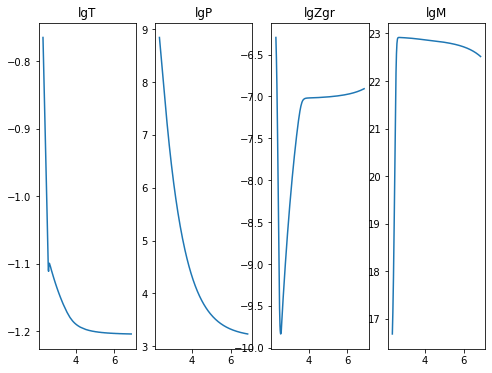

2020-05-31 04:49:31,318 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s
2020-05-31 04:49:31,516 __main__ 0/1 INFO :: Perturbation norm: 12.501827877710394
2020-05-31 04:49:31,517 __main__ 0/1 INFO :: lgT iterate: -0.9233729012022627
2020-05-31 04:49:31,518 __main__ 0/1 INFO :: lgP iterate: 8.992028545606331
2020-05-31 04:49:31,519 __main__ 0/1 INFO :: lgM iterate: 21.426056516889197
2020-05-31 04:49:31,519 __main__ 0/1 INFO :: lgZgr iterate: -9.845629937285558


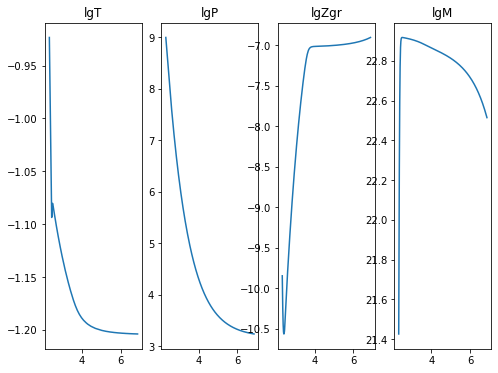

2020-05-31 04:49:34,139 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+00/s
2020-05-31 04:49:34,338 __main__ 0/1 INFO :: Perturbation norm: 3.0587853001423113
2020-05-31 04:49:34,339 __main__ 0/1 INFO :: lgT iterate: -1.0565160528679471
2020-05-31 04:49:34,340 __main__ 0/1 INFO :: lgP iterate: 9.032466639728863
2020-05-31 04:49:34,340 __main__ 0/1 INFO :: lgM iterate: 22.91926146068184
2020-05-31 04:49:34,342 __main__ 0/1 INFO :: lgZgr iterate: -11.081253056555548


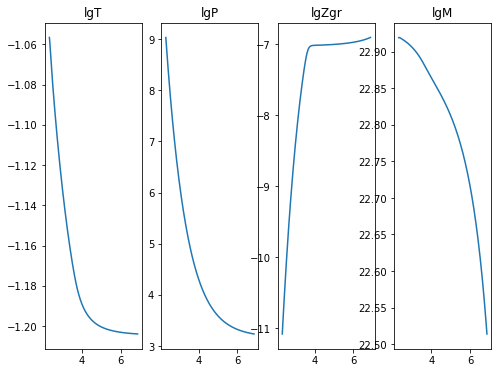

2020-05-31 04:49:36,672 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s
2020-05-31 04:49:36,852 __main__ 0/1 INFO :: Perturbation norm: 0.004687117717184174
2020-05-31 04:49:36,852 __main__ 0/1 INFO :: lgT iterate: -1.0548450487950811
2020-05-31 04:49:36,853 __main__ 0/1 INFO :: lgP iterate: 9.033885191116214
2020-05-31 04:49:36,854 __main__ 0/1 INFO :: lgM iterate: 22.92001500316659
2020-05-31 04:49:36,855 __main__ 0/1 INFO :: lgZgr iterate: -11.080667501262495


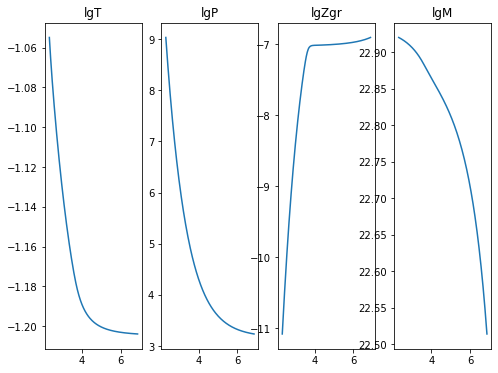

2020-05-31 04:49:38,853 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.1e+00/s
2020-05-31 04:49:39,027 __main__ 0/1 INFO :: Perturbation norm: 1.9049721349415152e-07
2020-05-31 04:49:39,028 __main__ 0/1 INFO :: lgT iterate: -1.0548450752635095
2020-05-31 04:49:39,029 __main__ 0/1 INFO :: lgP iterate: 9.033885238143348
2020-05-31 04:49:39,029 __main__ 0/1 INFO :: lgM iterate: 22.920015005791395
2020-05-31 04:49:39,030 __main__ 0/1 INFO :: lgZgr iterate: -11.080667589725472


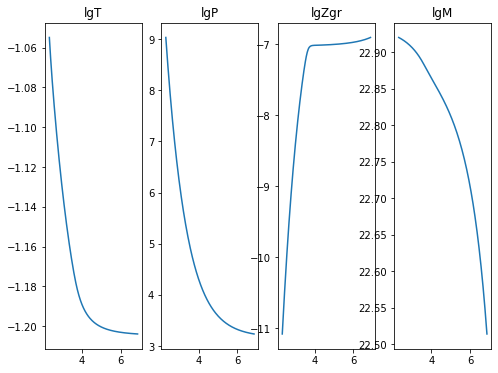

2020-05-31 04:49:41,045 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+00/s
2020-05-31 04:49:41,261 __main__ 0/1 INFO :: Perturbation norm: 3.0705291503811085e-09
2020-05-31 04:49:41,262 __main__ 0/1 INFO :: lgT iterate: -1.0548450752613179
2020-05-31 04:49:41,266 __main__ 0/1 INFO :: lgP iterate: 9.033885238125425
2020-05-31 04:49:41,267 __main__ 0/1 INFO :: lgM iterate: 22.92001500577443
2020-05-31 04:49:41,271 __main__ 0/1 INFO :: lgZgr iterate: -11.080667589691382


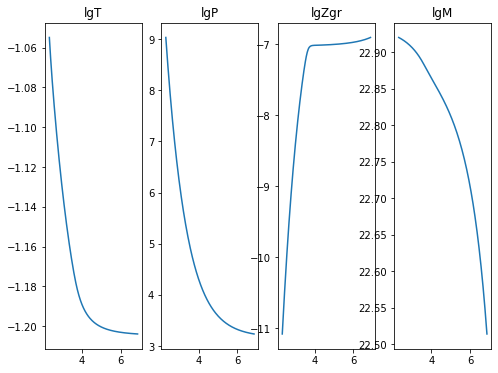

2020-05-31 04:49:43,638 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+00/s
2020-05-31 04:49:43,960 __main__ 0/1 INFO :: Perturbation norm: 4.849897232610806e-10
2020-05-31 04:49:43,961 __main__ 0/1 INFO :: lgT iterate: -1.0548450752613814
2020-05-31 04:49:43,964 __main__ 0/1 INFO :: lgP iterate: 9.033885238123782
2020-05-31 04:49:43,967 __main__ 0/1 INFO :: lgM iterate: 22.920015005775557
2020-05-31 04:49:43,969 __main__ 0/1 INFO :: lgZgr iterate: -11.080667589690345


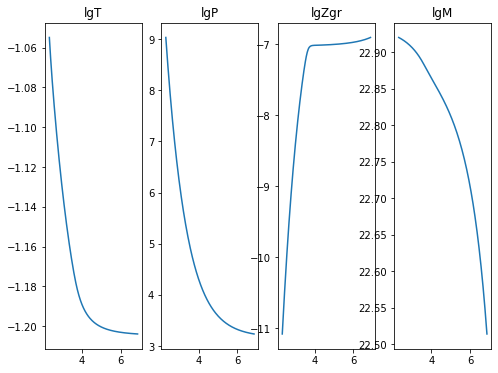

2020-05-31 04:49:46,137 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s
2020-05-31 04:49:46,619 __main__ 0/1 INFO :: Perturbation norm: 7.831742980624987e-11
2020-05-31 04:49:46,621 __main__ 0/1 INFO :: lgT iterate: -1.0548450752613945
2020-05-31 04:49:46,621 __main__ 0/1 INFO :: lgP iterate: 9.033885238123531
2020-05-31 04:49:46,636 __main__ 0/1 INFO :: lgM iterate: 22.92001500577577
2020-05-31 04:49:46,637 __main__ 0/1 INFO :: lgZgr iterate: -11.080667589690208


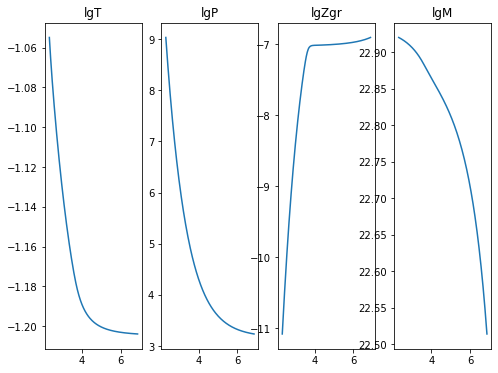

In [18]:
# Iterations

i = 0

pert = solver.perturbations.data
pert.fill(1+tolerance)
start_time = time.time()
while np.sum(np.abs(pert)) > tolerance:
    solver.newton_iteration()
    lgT_list.append(np.copy(lgT1['g'])) # save
    lgP_list.append(np.copy(lgP1['g']))
    lgZgr_list.append(np.copy(lgZgr1['g'])) 
    lgM_list.append(np.copy(lgM1['g'])) 
    logger.info('Perturbation norm: {}'.format(np.sum(np.abs(pert))))
    logger.info('lgT iterate: {}'.format(lgT1['g'][0]))
    logger.info('lgP iterate: {}'.format(lgP1['g'][0]))
    logger.info('lgM iterate: {}'.format(lgM1['g'][0]))
    logger.info('lgZgr iterate: {}'.format(lgZgr1['g'][0]))
    
    plt.figure(figsize=(8,6))
    plt.subplot(1,4,1)
    plt.plot(domain.grid(0),lgT1['g'])
    plt.title("lgT")
    plt.subplot(1,4,2)
    plt.plot(domain.grid(0), lgP1['g'])
    plt.title("lgP")
    plt.subplot(1,4,3)
    plt.plot(domain.grid(0),lgZgr1['g'])
    plt.title("lgZgr")
    plt.subplot(1,4,4)
    plt.plot(domain.grid(0), lgM1['g'])
    plt.title("lgM")
    plt.show()
    
end_time = time.time()

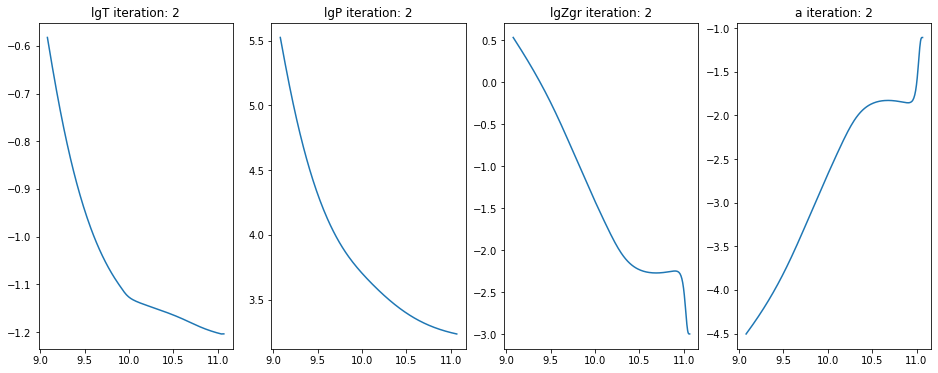

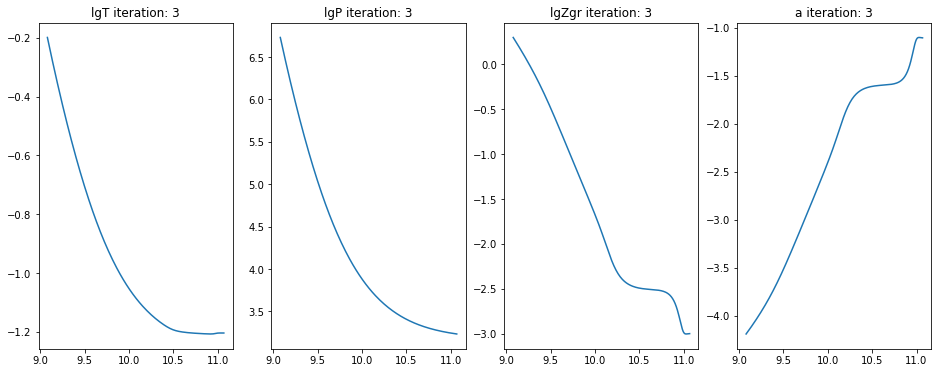

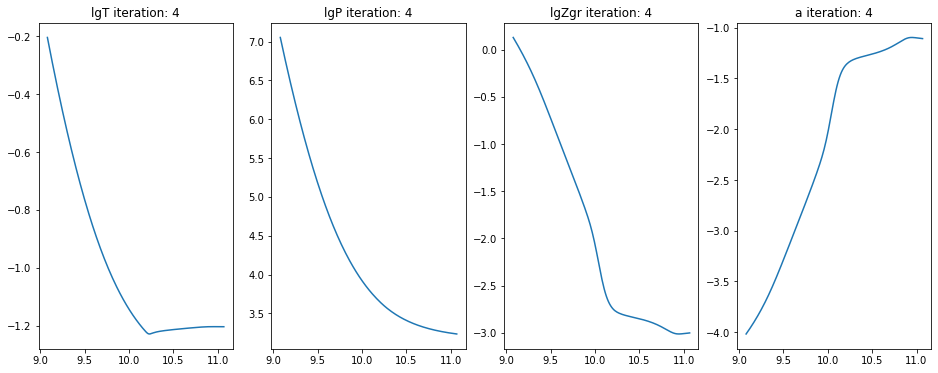

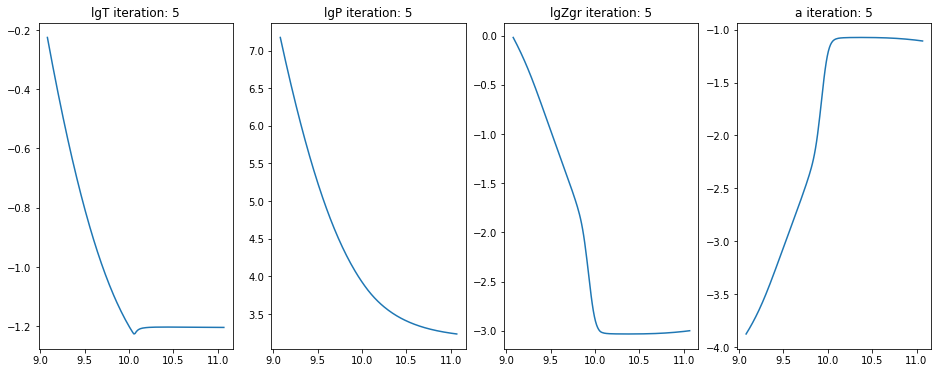

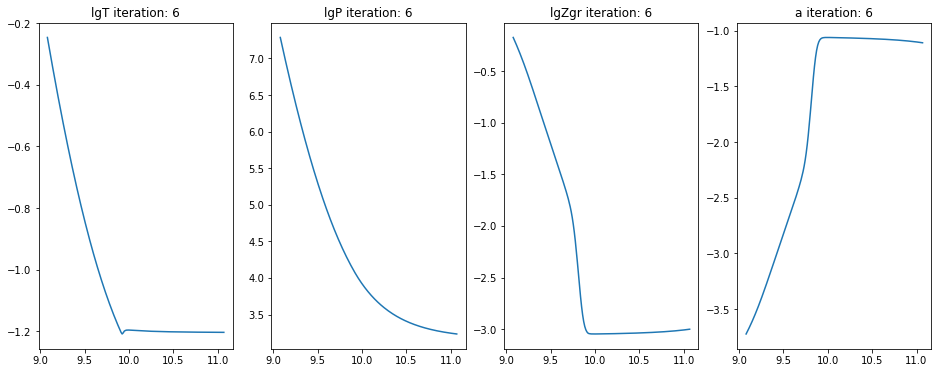

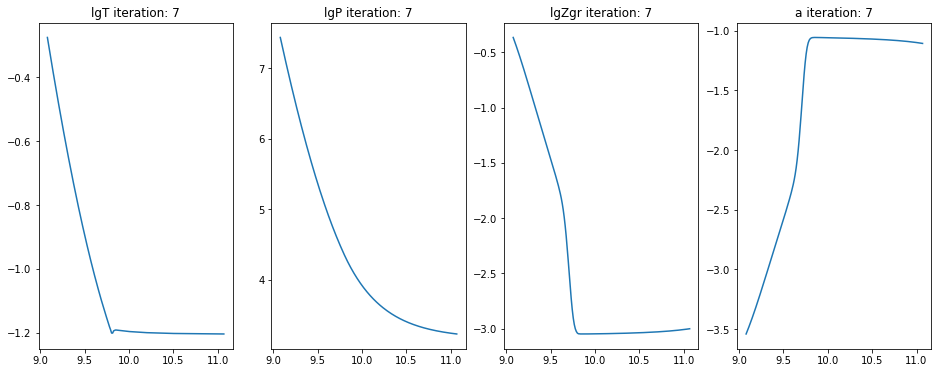

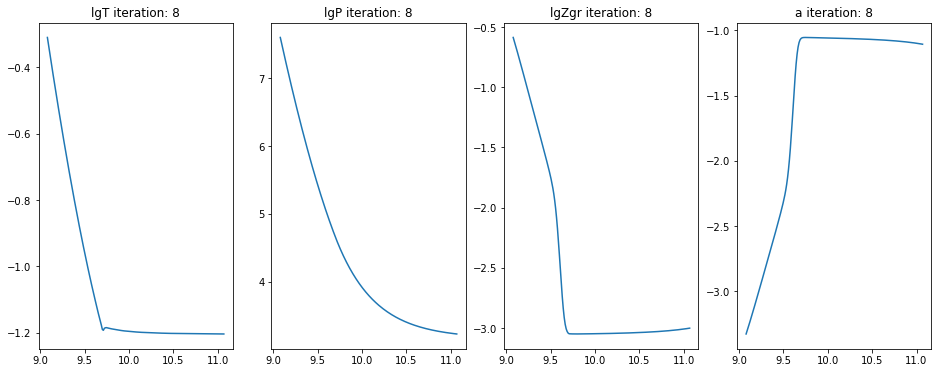

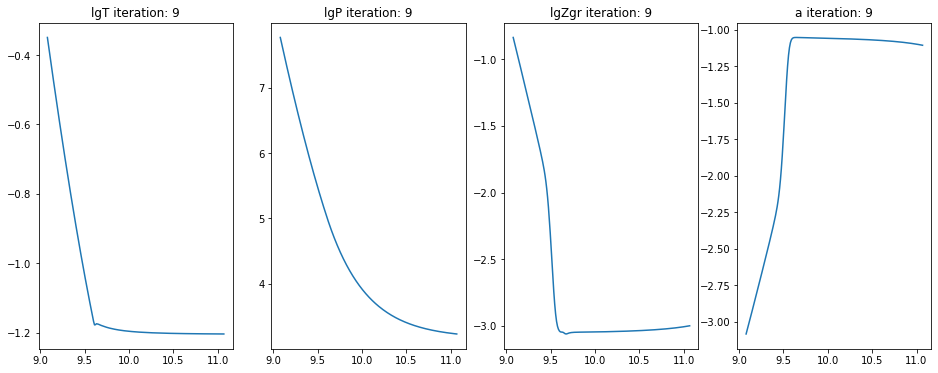

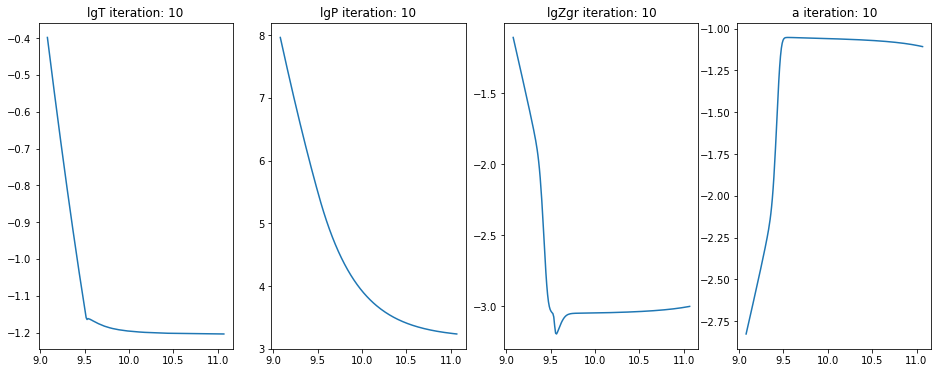

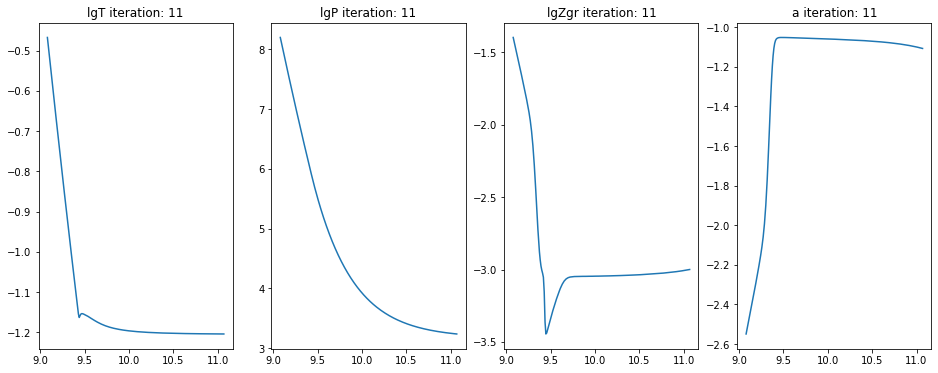

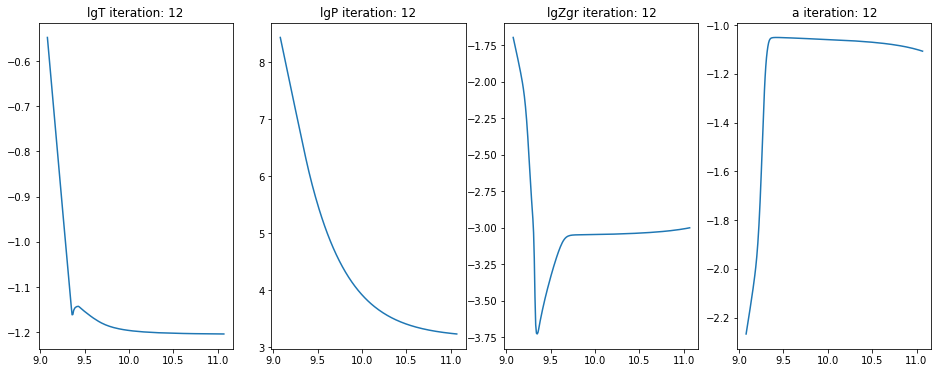

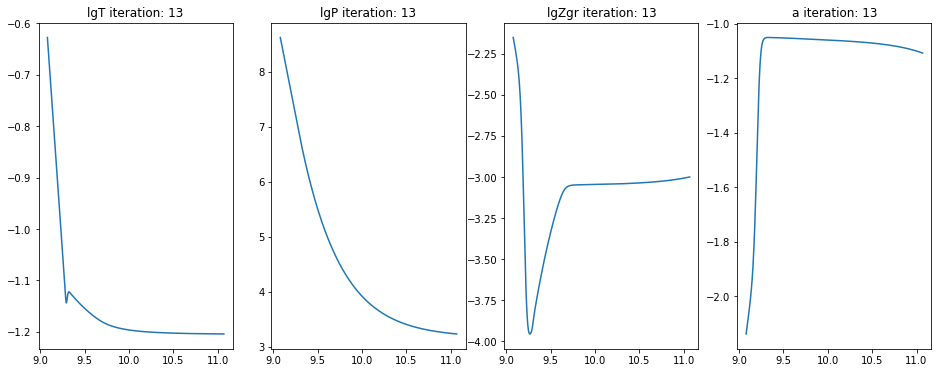

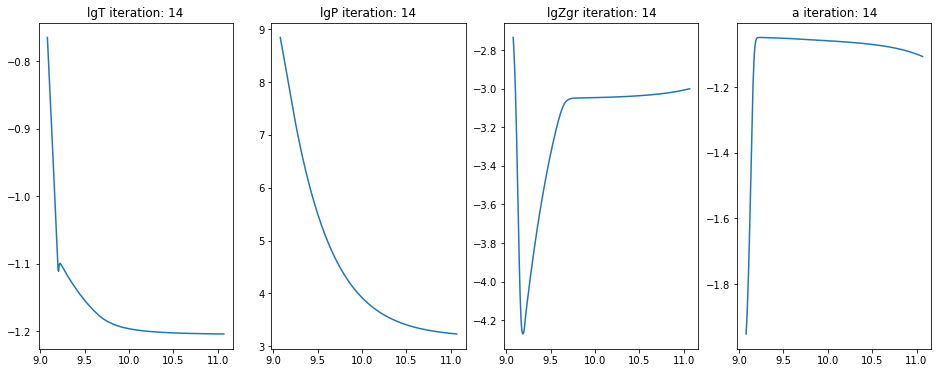

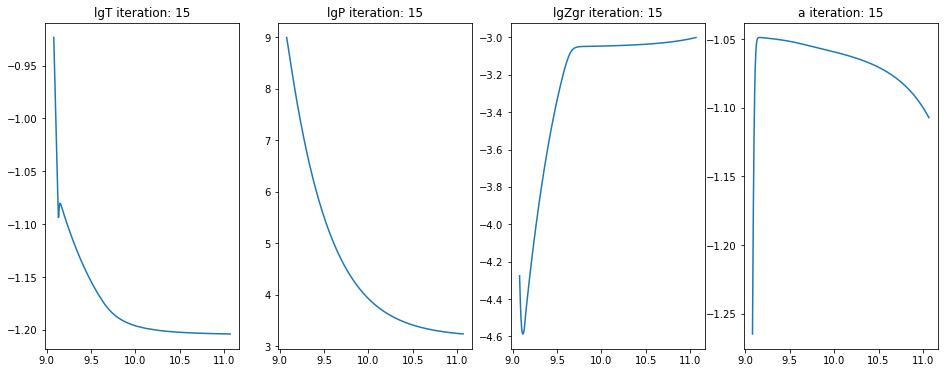

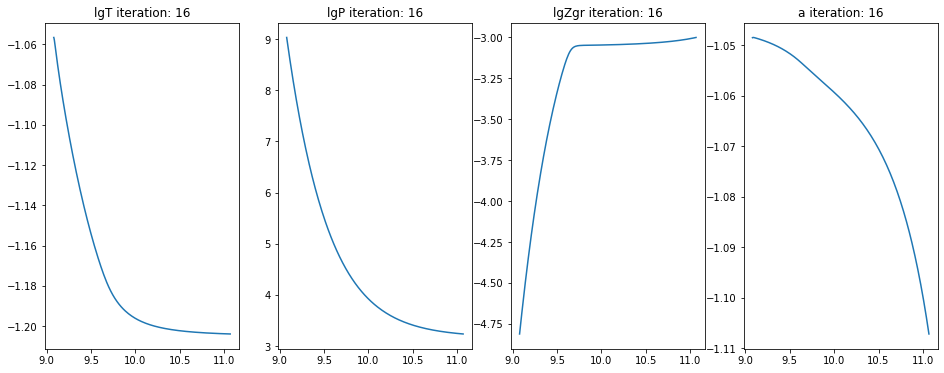

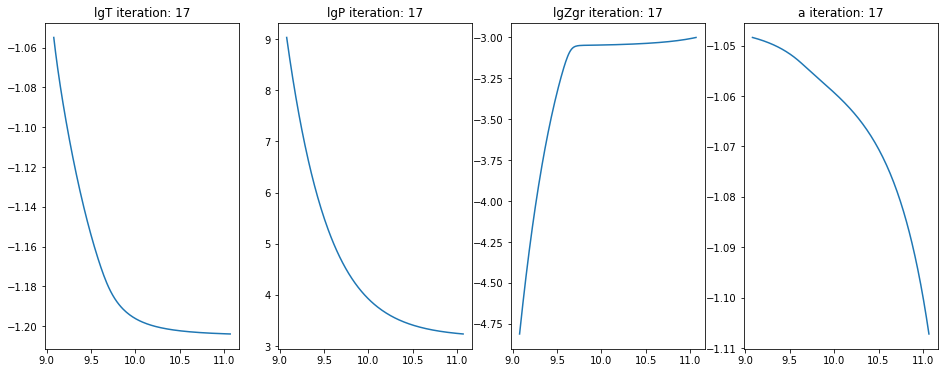

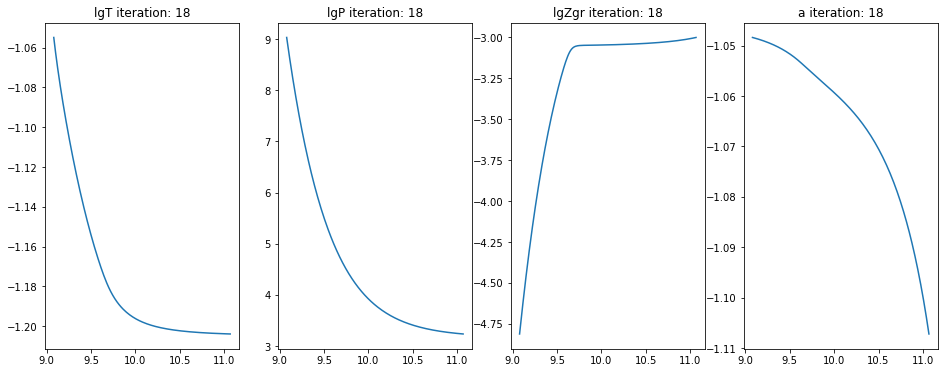

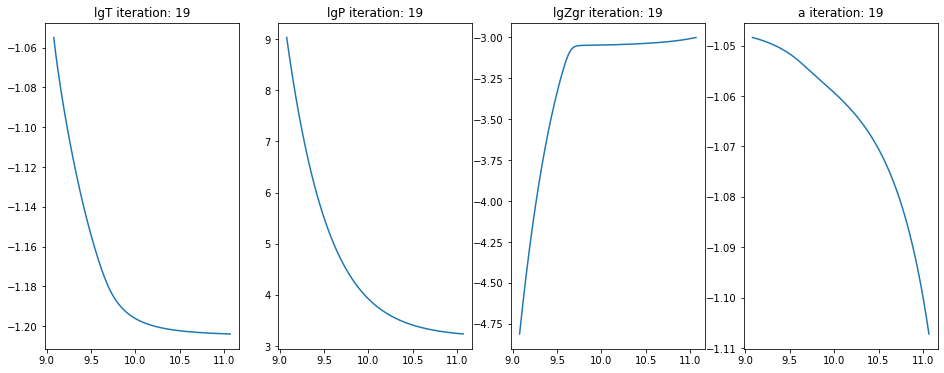

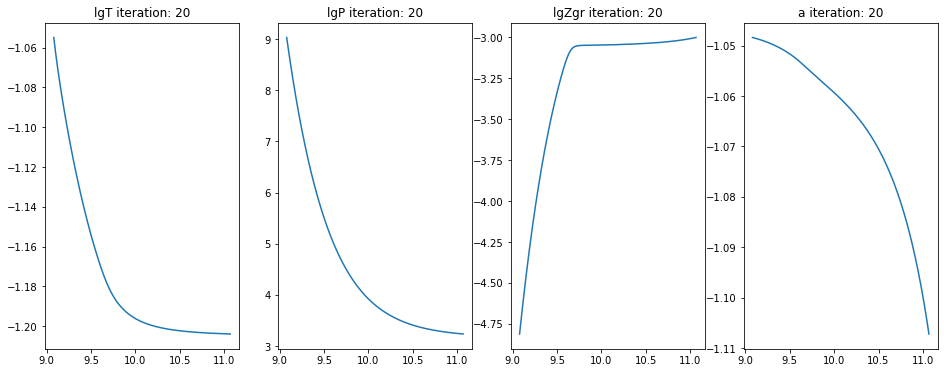

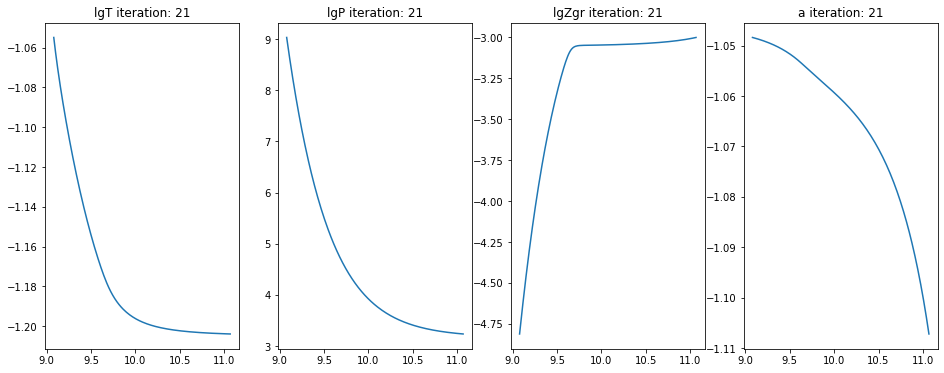

In [19]:
lower = 0 
if len(lgT_list) > 20:
    lower = len(lgT_list) - 20

R = np.log10(np.exp(domain.grid(0))*r_0)

for i in range(lower,len(lgT_list)):
        plt.figure(figsize=(16,6))
        
        plt.subplot(1,4,1)
        plt.plot(R,lgT_list[i])

        plt.title("lgT iteration: " + str(i))
        
        plt.subplot(1,4,2)
        plt.plot(R, lgP_list[i])
        plt.title("lgP iteration: " + str(i))
        
        plt.subplot(1,4,3)
        plt.plot(R, np.log10(np.exp(lgZgr_list[i])))
        plt.title("lgZgr iteration: " + str(i))
        
        # Grain size 
        plt.subplot(1,4,4)
        plt.plot(R, np.log10((np.exp(lgM_list[i])*M_0/(4*np.pi))**(1/3)))
        plt.title("a iteration: " + str(i))  

In [20]:
np.savetxt("Pressure.txt", lgP_list[-1])
np.savetxt("Temperature.txt", lgT_list[-1])
np.savetxt("Zgr.txt", lgZgr_list[-1])
np.savetxt("M.txt", lgM_list[-1])

lgP['g'] = lgP_list[-1]
lgT['g'] = lgT_list[-1]
lgZgr['g'] = lgZgr_list[-1]
lgM['g'] = lgM_list[-1]

Text(0.5, 1.0, 'Grad')

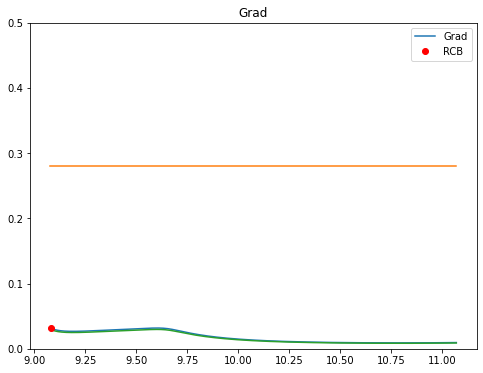

In [21]:
# Grad

Grad = grad.evaluate()
Grad.require_grid_space()
Grad_rad = grad_rad.evaluate()
Grad_rad.require_grid_space()

RCB = 0
epsilon = 0.0001
for i in range(0, len(Grad['g'] - 1)):
    if np.abs(Grad['g'][i] - Grad['g'][0]) >  epsilon:
        RCB = i
        break

plt.figure(figsize=(8,6))
plt.plot(R, Grad['g'], label='Grad')
plt.plot(R, grad_ad*np.ones(len(R)))
plt.plot(R, -Grad_rad['g'])
plt.plot(R[RCB], Grad['g'][RCB], 'ro', label = 'RCB')
plt.ylim(0, 0.5)
plt.legend()

plt.title('Grad')

Trcb_set = 7.925973707213242e-06 yr
Tbondi_set = 0.464571136962065 yr
Tout_set = 540.0436206505979 yr


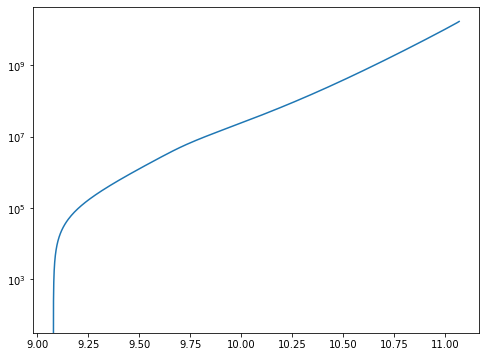

In [22]:
Bondi = r_Bondi # cm
# Bondi = 8.9442713e10
# Tsettl = r/vsettl 
def find_nearest_index(A, x):
    i = (np.abs(A - x)).argmin()
    return i

bondi = find_nearest_index(R, np.log10(Bondi))
Vsettl = v_set.evaluate()
Vsettl.require_grid_space()
Vset = Vsettl['g']

Tsettl = np.ones(len(R))

for i in range(0, len(R)):
    Tsettl[i] = np.trapz(1/Vset[0:i], S[0:i]) # Ormel integral definition 
    
# Tsettl = np.exp(r['g'])*r_0/Vset 
    
plt.figure(figsize=(8,6))
plt.plot(R, Tsettl)
plt.yscale('log')


Trcb_set = Tsettl[RCB]
Tbondi_set = Tsettl[bondi]
Tout_set = Tsettl[-1]

yr = 3.154e+7

print("Trcb_set = {} yr".format(Trcb_set/yr))
print("Tbondi_set = {} yr".format(Tbondi_set/yr))
print("Tout_set = {} yr".format(Tout_set/yr))

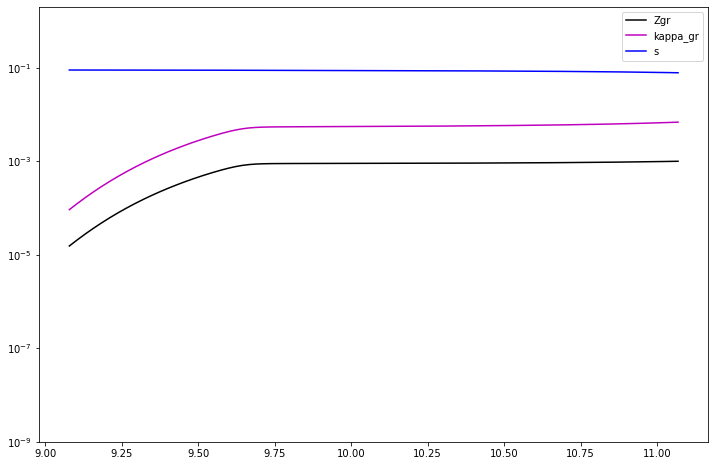

In [23]:
# Ormel profilel 

size = s.evaluate()
size.require_grid_space()
kappa_gr = Qk_geo.evaluate()
kappa_gr.require_grid_space()

plt.figure(figsize=(12,8))
plt.plot(R, np.exp(lgZgr['g']), 'k-', label='Zgr')
plt.plot(R, kappa_gr['g'], 'm-', label='kappa_gr')
plt.plot(R, size['g'], 'b-', label='s')
plt.yscale('log')
plt.ylim((1e-9, 0.2e1))
plt.legend()

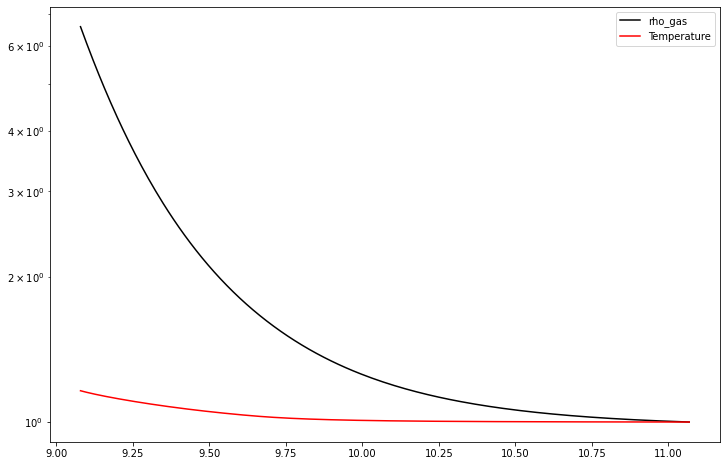

In [24]:
rho_gas = rho_g.evaluate()
rho_gas.require_grid_space()

lgT = lgT_list[-1]

plt.figure(figsize=(12,8)) 
plt.plot(R, (rho_gas['g']/rhodisk)**(1/3), 'k-', label='rho_gas')
plt.plot(R, np.exp(lgT)*T_0/Tdisk, 'r-', label='Temperature') 
plt.yscale('log')
plt.legend()
lgP = domain.new_field(name='lgP')
lgT = domain.new_field(name='lgT')
lgZgr = domain.new_field(name='lgZgr')
lgM = domain.new_field(name='lgM')
lgP['g'] = lgP_list[-1]
lgT['g'] = lgT_list[-1]
lgZgr['g'] = lgZgr_list[-1]
lgM['g'] = lgM_list[-1]

r = domain.new_field(name='R')
r['g'] = domain.grid(0)
S = np.exp(r['g']) * r_0

pi = np.pi 
rho_o = 3 
Mc = Core_mass # 5* mass of earth (in g)
mu = 2.34 * 1.6735575e-24 #mH multiplied by hydrogen atom mass 
kb = 1.38064852e-16 # g*cm**2/(K*s**2)
G = 6.67408e-8 # cm**3/(g*s**2)
dMtot = 1e-5*5.972e27/3.154e7 # 10e-5* mass of earth, g/s #3.154e7 is conversion from yr to s
sig = 5.670367e-5 # (cgs units) e-5 in g/(K^4s^3), Stefan Boltzmann Const (normally it's e-8 in [W⋅m−2⋅K−4])
s0 = 1e-4 # cm
rho_o = 3 #g cm^-3 grain internal density
sigma_b = 5.6704e-5 # erg*cm^-2*s^-1*K^-4 Stefan Boltzmann 
rcore = 1.2e9
grad_rad_cst = - 3*problem.parameters['dMtot']/(64*np.pi*rcore*problem.parameters['sig'])

rhodisk = 1e-11 #g/cm**3
Tdisk = 150 # kelvin

s = (np.exp(lgM)*M_0*3/(4*pi*rho_o))**(1/3)



Envelope mass (g): 1.662207e+25


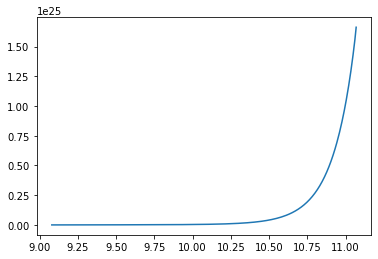

In [25]:
Env = np.zeros(len(R))

En = 4*np.pi*(np.exp(r)*r_0)**2 *rho_g 

m = En.evaluate()
m.require_grid_space()

for i in range(0, len(R)):
    Env[i] = np.trapz(m['g'][0:i], S[0:i]) 
    
    
plt.plot(R, Env)
env_mass = Env[-1]
print("Envelope mass (g): {:e}".format(env_mass))

(-0.3, 0.4)

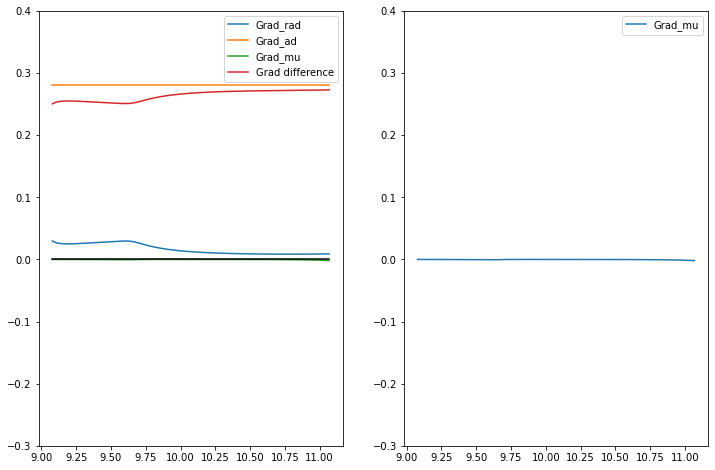

In [26]:
lgMu = np.log(1+np.exp(lgZgr))
dlgMu = log_basis.Differentiate(lgMu)
dlgP = log_basis.Differentiate(np.log(np.exp(lgP) *P_0))

grad_mu = dlgMu/dlgP

# grad_mu1 = np.diff( np.log(1+np.exp(lgZgr['g'])))/ np.diff(np.log(np.exp(lgP['g']) *P_0)) 
Grad_mu = grad_mu.evaluate()
Grad_mu.require_grid_space()

grad_diff = grad_rad - grad_mu - (-grad_ad) 
Grad_diff = grad_diff.evaluate() 
Grad_diff.require_grid_space() 


plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
# plt.plot(R, Grad_diff['g'])
# plt.plot(R,Grad_mu['g'])
plt.plot(R, -Grad_rad['g'], label = 'Grad_rad')
plt.plot(R, grad_ad*np.ones(len(R)), label = 'Grad_ad')
plt.plot(R, Grad_mu['g'], label = 'Grad_mu')
plt.plot(R, Grad_diff['g'], label = 'Grad difference')
plt.plot(R, np.zeros(len(R)), 'k-') 
plt.legend()
plt.ylim((-0.3, 0.4))
plt.subplot(1,2,2)
plt.plot(R, Grad_mu['g'], label = 'Grad_mu')
# plt.plot(R[1:], grad_mu1)
plt.legend()
plt.ylim((-0.3, 0.4))

In [27]:
dlgZgr = lgZgr.differentiate('r')
dlgP = lgP.differentiate('r')
# Multiply dlgZgr by Zgr to get dZgr (as a proxy for dmu = d(1+Zgr) = dZgr)
grad_mu= dlgZgr['g']/ dlgP['g']
grad_mu *= np.exp(lgZgr['g'])

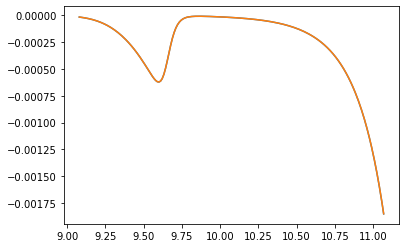

In [28]:
plt.plot(R, grad_mu)
plt.plot(R, Grad_mu['g'], label = 'Grad_mu')